In [4]:
import os
from pathlib import Path
from typing import Optional, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
import masknmf
from typing import *

In [5]:
class MotionBinDataset:
    """Load a memmapped suite2p data.bin together with metadata (.npy/.zip)."""
    def __init__(self, data_path: str, metadata_path: str, dtype=np.int16):
        self.bin_path = Path(data_path)
        self.ops_path = Path(metadata_path)
        self._dtype = dtype
        self._shape = self._compute_shape()
        self.data = np.memmap(self.bin_path, mode='r', dtype=self._dtype, shape=self._shape)

    def _compute_shape(self) -> Tuple[int, int, int]:
        _, ext = os.path.splitext(self.ops_path)
        if ext == ".zip":
            ops = np.load(self.ops_path, allow_pickle=True)['ops'].item()
        elif ext == ".npy":
            ops = np.load(self.ops_path, allow_pickle=True).item()
        else:
            raise ValueError("Metadata file must be .zip or .npy")
        return int(ops['nframes']), int(ops['Ly']), int(ops['Lx'])

    @property
    def shape(self) -> Tuple[int, int, int]:
        return self._shape

    def __getitem__(self, item):
        return self.data[item].copy()

config = {
    'bin_file_path': '/burg-archive/home/lm3879/plane4/data.bin',
    'ops_file_path': '/burg-archive/home/lm3879/plane4/ops.npy',
    'out_path': '/burg-archive/home/lm3879/masknmf-toolbox/ibl_denoised_output/pmd_spatial_results.npz',
    'block_size': (32, 32),
    'max_components': 20,
    'device': 'cuda',
    'spatial_epochs': 5,
    'spatial_batch_size': 32,
    'spatial_lr': 1e-4,
    'temporal_epochs': 5,
    'temporal_batch_size': 128,
    'temporal_lr': 1e-4,
    'noise_quantile': 0.7,
    'patch_h': 40,
    'patch_w': 40,
}

cfg = OmegaConf.create(config)
print(f"Using device: {cfg.device}")

# Load data
my_data = MotionBinDataset(cfg.bin_file_path, cfg.ops_file_path)
print(f"Loaded data with shape (T,H,W): {my_data.shape}")


Using device: cuda
Loaded data with shape (T,H,W): (11700, 500, 620)


In [7]:
print("\n" + "="*60)
print("Running PMD with Temporal Denoising")
print("="*60)
pmd_temporal = masknmf.CompressTemporalDenoiseStrategy(
    dataset=my_data,
    block_sizes=cfg.block_size,
    max_components=cfg.max_components,
    noise_variance_quantile=cfg.noise_quantile,
    num_epochs=cfg.temporal_epochs,
    device=cfg.device
).compress()

print(f"PMD rank (temporal only): {pmd_temporal.pmd_rank}")



Running PMD with Temporal Denoising
[25-12-12 01:18:34]: Starting compression
[25-12-12 01:18:34]: sampled from the following regions: [0]
[25-12-12 01:18:34]: We are initializing on a total of 11700 frames
[25-12-12 01:18:43]: Loading data to estimate complete spatial basis
[25-12-12 01:18:43]: skipping the pruning step for frame cutoff
[25-12-12 01:18:43]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:00<00:00, 264.18it/s]

[25-12-12 01:18:44]: Running Blockwise Decompositions


[25-12-12 01:19:23]: Constructed U matrix. Rank of U is 2584
[25-12-12 01:19:24]: PMD Objected constructed


Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/burg-archive/home/lm3879/miniconda3/envs/py311v2/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /burg-archive/home/lm3879/masknmf-toolbox/masknmf/compression/lightning_logs/version_5260122/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name             | Type            | Params | Mode 
-------------------------------------------------------------
0 | temporal_network | TemporalNetwork | 278 K  | train
-------------------------------------------------------------
170 K     Trainable params
107 K     Non-trainable params
278 K     Total params
1.114     Total estimated mo

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


[25-12-12 01:21:02]: Starting compression
[25-12-12 01:21:02]: sampled from the following regions: [0]
[25-12-12 01:21:02]: We are initializing on a total of 11700 frames
[25-12-12 01:21:10]: Loading data to estimate complete spatial basis
[25-12-12 01:21:10]: skipping the pruning step for frame cutoff
[25-12-12 01:21:10]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:04<00:00, 59.09it/s]

[25-12-12 01:21:14]: Running Blockwise Decompositions


[25-12-12 01:26:24]: Constructed U matrix. Rank of U is 2732
[25-12-12 01:26:24]: PMD Objected constructed
PMD rank (temporal only): 2732


In [8]:
print("\n" + "="*60)
print("Running PMD with Spatial Denoising")
print("="*60)

pmd_spatial = CompressSpatialDenoiseStrategy(
    dataset=my_data,
    block_sizes=cfg.block_size,
    max_components=cfg.max_components,
    spatial_denoiser_epochs=cfg.spatial_epochs,
    spatial_denoiser_batch_size=cfg.spatial_batch_size,
    spatial_denoiser_lr=cfg.spatial_lr,
    noise_variance_quantile=cfg.noise_quantile,
    patch_h=cfg.patch_h,
    patch_w=cfg.patch_w,
    device=cfg.device
).compress()

print(f"PMD rank (spatial only): {pmd_spatial.pmd_rank}")



Running PMD with Spatial Denoising

STEP 1: Initial PMD decomposition (no denoiser)
[25-12-12 01:26:25]: Starting compression
[25-12-12 01:26:25]: sampled from the following regions: [0]
[25-12-12 01:26:25]: We are initializing on a total of 11700 frames
[25-12-12 01:26:32]: Loading data to estimate complete spatial basis
[25-12-12 01:26:32]: skipping the pruning step for frame cutoff
[25-12-12 01:26:32]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:05<00:00, 44.89it/s]

[25-12-12 01:26:38]: Running Blockwise Decompositions


[25-12-12 01:28:16]: Constructed U matrix. Rank of U is 2565
[25-12-12 01:28:17]: PMD Objected constructed
Initial PMD rank: 2565

STEP 2: Training spatial denoiser
Spatial components shape: torch.Size([2565, 500, 620])

Starting Spatial Denoiser Training
Device: cuda
GPU: Quadro RTX 8000
Total memory: 44.30 GB

Extracting valid patches from spatial components...
  Processed 500/2565 components...
  Processed 1000/2565 components...
  Processed 1500/2565 components...
  Processed 2000/2565 components...
  Processed 2500/2565 components...

Extracted 2565 valid patches from 2565 components


📊 Patch Statistics:
  Number of patches: 2565
  Size range: 34 - 36 pixels
  Average size: 1288 pixels


Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | spatial_network | SpatialNetwork | 509 K  | train
-----------------------------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Dataset created: 2565 patches
Memory footprint: 0.01 GB
Using 2565 random patches for training
DataLoader ready with 81 batches

Starting training...
Effective batch size: 64


/burg-archive/home/lm3879/miniconda3/envs/py311v2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Training complete!
Peak GPU memory: 1.38 GB

Blindspot leakage test: 0.00e+00
✓ Blindspot property verified

✓ PMD spatial denoiser created
  Noise variance quantile: 0.7
  Padding: 12
  Device: cuda

STEP 3: Final PMD decomposition (with spatial denoiser)
[25-12-12 01:30:18]: Starting compression
[25-12-12 01:30:18]: sampled from the following regions: [0]
[25-12-12 01:30:18]: We are initializing on a total of 11700 frames
[25-12-12 01:30:26]: Loading data to estimate complete spatial basis
[25-12-12 01:30:26]: skipping the pruning step for frame cutoff
[25-12-12 01:30:26]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:08<00:00, 30.28it/s]

[25-12-12 01:30:34]: Running Blockwise Decompositions


[25-12-12 01:33:28]: Constructed U matrix. Rank of U is 2664
[25-12-12 01:33:29]: PMD Objected constructed

Final PMD rank (with spatial denoiser): 2664
Rank change: 2565 -> 2664

PMD rank (spatial only): 2664


In [9]:
print("\n" + "="*60)
print("Running PMD with Spatial + Temporal Denoising")
print("="*60)

pmd_both = CompressSpatialTemporalDenoiseStrategy(
    dataset=my_data,
    block_sizes=cfg.block_size,
    max_components=cfg.max_components,
    # Spatial denoiser
    spatial_denoiser_epochs=cfg.spatial_epochs,
    spatial_denoiser_batch_size=cfg.spatial_batch_size,
    spatial_denoiser_lr=cfg.spatial_lr,
    spatial_noise_variance_quantile=cfg.noise_quantile,
    patch_h=cfg.patch_h,
    patch_w=cfg.patch_w,
    # Temporal denoiser
    temporal_denoiser_epochs=cfg.temporal_epochs,
    temporal_denoiser_batch_size=cfg.temporal_batch_size,
    temporal_denoiser_lr=cfg.temporal_lr,
    temporal_noise_variance_quantile=cfg.noise_quantile,
    device=cfg.device
).compress()

print(f"PMD rank (spatial + temporal): {pmd_both.pmd_rank}")



Running PMD with Spatial + Temporal Denoising

STEP 1: Initial PMD decomposition (no denoisers)
[25-12-12 01:33:29]: Starting compression
[25-12-12 01:33:29]: sampled from the following regions: [0]
[25-12-12 01:33:29]: We are initializing on a total of 11700 frames
[25-12-12 01:33:37]: Loading data to estimate complete spatial basis
[25-12-12 01:33:37]: skipping the pruning step for frame cutoff
[25-12-12 01:33:37]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:00<00:00, 260.86it/s]

[25-12-12 01:33:38]: Running Blockwise Decompositions


[25-12-12 01:34:18]: Constructed U matrix. Rank of U is 2575
[25-12-12 01:34:19]: PMD Objected constructed
Initial PMD rank: 2575

STEP 2: Training spatial denoiser

Starting Spatial Denoiser Training
Device: cuda
GPU: Quadro RTX 8000
Total memory: 44.30 GB

Extracting valid patches from spatial components...
  Processed 500/2575 components...
  Processed 1000/2575 components...
  Processed 1500/2575 components...
  Processed 2000/2575 components...
  Processed 2500/2575 components...

Extracted 2575 valid patches from 2575 components


📊 Patch Statistics:
  Number of patches: 2575
  Size range: 34 - 36 pixels
  Average size: 1288 pixels


Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | spatial_network | SpatialNetwork | 509 K  | train
-----------------------------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Dataset created: 2575 patches
Memory footprint: 0.01 GB
Using 2575 random patches for training
DataLoader ready with 81 batches

Starting training...
Effective batch size: 64


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name             | Type            | Params | Mode 
-------------------------------------------------------------
0 | temporal_network | TemporalNetwork | 278 K  | train
-------------------------------------------------------------
170 K     Trainable params
107 K     Non-trainable params
278 K     Total params
1.114     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training complete!
Peak GPU memory: 0.73 GB

Blindspot leakage test: 0.00e+00
✓ Blindspot property verified

✓ PMD spatial denoiser created
  Noise variance quantile: 0.7
  Padding: 12
  Device: cuda

STEP 3: Training temporal denoiser


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.



STEP 4: Final PMD decomposition (with both denoisers)
[25-12-12 01:38:24]: Starting compression
[25-12-12 01:38:24]: sampled from the following regions: [0]
[25-12-12 01:38:24]: We are initializing on a total of 11700 frames
[25-12-12 01:38:33]: Loading data to estimate complete spatial basis
[25-12-12 01:38:33]: skipping the pruning step for frame cutoff
[25-12-12 01:38:33]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:07<00:00, 34.57it/s]

[25-12-12 01:38:40]: Running Blockwise Decompositions


[25-12-12 01:44:44]: Constructed U matrix. Rank of U is 3835
[25-12-12 01:44:45]: PMD Objected constructed

Final PMD rank (with both denoisers): 3835
Rank change: 2575 -> 3835

PMD rank (spatial + temporal): 3835


In [10]:
print("\n" + "="*60)
print("Summary of Results")
print("="*60)
print(f"Temporal only:      rank = {pmd_temporal.pmd_rank}")
print(f"Spatial only:       rank = {pmd_spatial.pmd_rank}")
print(f"Spatial + Temporal: rank = {pmd_both.pmd_rank}")
print("="*60 + "\n")



Summary of Results
Temporal only:      rank = 2732
Spatial only:       rank = 2664
Spatial + Temporal: rank = 3835



RFBOutputContext()

Max vertex attribute stride unknown. Assuming it is 2048
/burg-archive/home/lm3879/miniconda3/envs/py311v2/lib/python3.11/site-packages/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
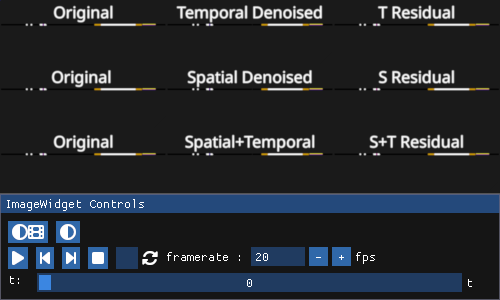

In [15]:
pmd_temporal.to('cuda')
pmd_spatial.to('cuda')
pmd_both.to('cuda')
import fastplotlib as fpl

# Compute residuals
residual_temporal = masknmf.PMDResidualArray(my_data, pmd_temporal)
residual_spatial = masknmf.PMDResidualArray(my_data, pmd_spatial)
residual_both = masknmf.PMDResidualArray(my_data, pmd_both)

# Create comprehensive comparison visualization
data = my_data.data
iw = fpl.ImageWidget(
    data=[
        data, pmd_temporal, residual_temporal,
        data, pmd_spatial, residual_spatial,
        data, pmd_both, residual_both
    ],
    figure_shape=(3, 3),
    names=[
        'Original', 'Temporal Denoised', 'T Residual',
        'Original ', 'Spatial Denoised', 'S Residual',
        ' Original ', 'Spatial+Temporal', 'S+T Residual'
    ]
)
iw.show()

In [13]:
import matplotlib.pyplot as plt

class SpatialComponentComparison:
    """Compare spatial components before and after denoising."""
    
    def __init__(self, 
                 pmd_before, 
                 pmd_after, 
                 data_shape,
                 top_k=12,
                 zoom_padding=2):
        """
        Parameters
        ----------
        pmd_before : PMDArray
            PMD result before denoising
        pmd_after : PMDArray
            PMD result after denoising
        data_shape : tuple
            (T, H, W) shape of original data
        top_k : int
            Number of top components to display
        zoom_padding : int
            Padding around detected regions
        """
        self.pmd_before = pmd_before
        self.pmd_after = pmd_after
        self.H, self.W = data_shape[1], data_shape[2]
        self.top_k = top_k
        self.zoom_padding = zoom_padding
        
        # Extract and reshape spatial components
        self.u_before = self._extract_components(pmd_before)
        self.u_after = self._extract_components(pmd_after)
        
    def _extract_components(self, pmd):
        """Extract U matrix and reshape to (H, W, rank)."""
        u_dense = pmd.u.to_dense().cpu()
        if isinstance(u_dense, torch.Tensor):
            u_dense = u_dense.numpy()
        return u_dense.reshape(self.H, self.W, -1)
    
    def _compute_energy(self, u):
        """Compute L2 norm for each component."""
        return np.array([np.linalg.norm(u[:, :, i]) for i in range(u.shape[2])])
    
    def _detect_bbox(self, img, threshold_quantile=0.01):
        """Detect bounding box of active region."""
        img_abs = np.abs(img)
        
        if np.any(img_abs > 0):
            threshold = np.quantile(img_abs[img_abs > 0], threshold_quantile)
        else:
            return 0, img.shape[0], 0, img.shape[1]
        
        mask = img_abs > threshold
        if not np.any(mask):
            return 0, img.shape[0], 0, img.shape[1]
        
        rows = np.where(np.any(mask, axis=1))[0]
        cols = np.where(np.any(mask, axis=0))[0]
        
        if len(rows) == 0 or len(cols) == 0:
            return 0, img.shape[0], 0, img.shape[1]
        
        return rows[0], rows[-1] + 1, cols[0], cols[-1] + 1
    
    def _get_union_bbox(self, img1, img2):
        """Get union bounding box with padding."""
        bbox1 = self._detect_bbox(img1)
        bbox2 = self._detect_bbox(img2)
        
        row_min = max(0, min(bbox1[0], bbox2[0]) - self.zoom_padding)
        row_max = min(self.H, max(bbox1[1], bbox2[1]) + self.zoom_padding)
        col_min = max(0, min(bbox1[2], bbox2[2]) - self.zoom_padding)
        col_max = min(self.W, max(bbox1[3], bbox2[3]) + self.zoom_padding)
        
        return row_min, row_max, col_min, col_max
    
    def _match_components(self):
        """Match before/after components by correlation."""
        # Select top energy components
        energy_before = self._compute_energy(self.u_before)
        energy_after = self._compute_energy(self.u_after)
        
        n_before = min(400, len(energy_before))
        n_after = min(400, len(energy_after))
        
        idx_before = np.argsort(energy_before)[-n_before:][::-1]
        idx_after = np.argsort(energy_after)[-n_after:][::-1]
        
        # Normalize and compute correlation
        B = self.u_before.reshape(-1, self.u_before.shape[2])[:, idx_before].astype(np.float32)
        A = self.u_after.reshape(-1, self.u_after.shape[2])[:, idx_after].astype(np.float32)
        
        # Normalize columns
        B_norm = B / (np.linalg.norm(B, axis=0, keepdims=True) + 1e-8)
        A_norm = A / (np.linalg.norm(A, axis=0, keepdims=True) + 1e-8)
        
        # Compute correlation
        corr = np.abs(B_norm.T @ A_norm)
        
        # Match top_k components
        matches = []
        for i in range(min(self.top_k, len(idx_before))):
            j = np.argmax(corr[i, :])
            matches.append((idx_before[i], idx_after[j], corr[i, j]))
        
        return matches
    
    def visualize(self, save_prefix='component_comparison', components_per_figure=6):
        """
        Create comparison visualizations.
        
        Parameters
        ----------
        save_prefix : str
            Prefix for saved figure files
        components_per_figure : int
            Number of component comparisons per figure
        """
        print("\n" + "="*60)
        print("Comparing Spatial Components: Before vs After Denoising")
        print("="*60)
        
        matches = self._match_components()
        
        print(f"\nRank before: {self.u_before.shape[2]}")
        print(f"Rank after: {self.u_after.shape[2]}")
        print(f"\nTop {len(matches)} component matches:")
        for i, (idx_b, idx_a, corr) in enumerate(matches):
            print(f"  {i+1}. Before #{idx_b} → After #{idx_a}  (corr={corr:.3f})")
        
        # Prepare cropped data
        viz_data = []
        for idx_b, idx_a, corr in matches:
            before_img = self.u_before[:, :, idx_b]
            after_img = self.u_after[:, :, idx_a]
            
            # Align sign
            if np.sum(before_img * after_img) < 0:
                after_img = -after_img
            
            # Get crop region
            bbox = self._get_union_bbox(before_img, after_img)
            row_min, row_max, col_min, col_max = bbox
            
            # Crop
            b_crop = before_img[row_min:row_max, col_min:col_max]
            a_crop = after_img[row_min:row_max, col_min:col_max]
            
            viz_data.append({
                'before': b_crop,
                'after': a_crop,
                'diff': a_crop - b_crop,
                'idx_b': idx_b,
                'idx_a': idx_a,
                'corr': corr,
                'bbox': bbox
            })
        
        # Create figures
        n_figures = int(np.ceil(len(viz_data) / components_per_figure))
        
        for fig_idx in range(n_figures):
            start = fig_idx * components_per_figure
            end = min((fig_idx + 1) * components_per_figure, len(viz_data))
            
            self._plot_comparison(viz_data[start:end], 
                                save_path=f'{save_prefix}_{fig_idx+1}_of_{n_figures}.png')
        
        print(f"\n✓ Created {n_figures} comparison figure(s)")
        print("="*60 + "\n")
    
    def _plot_comparison(self, viz_data, save_path):
        """Plot comparison grid for a subset of components."""
        n = len(viz_data)
        fig, axes = plt.subplots(n, 3, figsize=(12, 3*n))
        
        if n == 1:
            axes = axes.reshape(1, -1)
        
        for i, data in enumerate(viz_data):
            b_crop = data['before']
            a_crop = data['after']
            diff = data['diff']
            
            vmax = max(np.abs(b_crop).max(), np.abs(a_crop).max())
            vmax_diff = np.abs(diff).max() if diff.size > 0 else 1
            
            # Get bbox for title
            row_min, row_max, col_min, col_max = data['bbox']
            
            # Before
            im0 = axes[i, 0].imshow(b_crop, cmap='gray', vmin=-vmax, vmax=vmax)
            axes[i, 0].axis('off')
            axes[i, 0].set_title(f"Before #{data['idx_b']}\n[{row_min}:{row_max}, {col_min}:{col_max}]", 
                               fontsize=9)
            plt.colorbar(im0, ax=axes[i, 0], fraction=0.046, pad=0.04)
            
            # After
            im1 = axes[i, 1].imshow(a_crop, cmap='gray', vmin=-vmax, vmax=vmax)
            axes[i, 1].axis('off')
            axes[i, 1].set_title(f"After #{data['idx_a']}\nCorr={data['corr']:.3f}", 
                               fontsize=9)
            plt.colorbar(im1, ax=axes[i, 1], fraction=0.046, pad=0.04)
            
            # Difference
            im2 = axes[i, 2].imshow(diff, cmap='seismic', vmin=-vmax_diff, vmax=vmax_diff)
            axes[i, 2].axis('off')
            mse = np.mean(diff**2)
            axes[i, 2].set_title(f"Difference\nMSE={mse:.2e}", fontsize=9)
            plt.colorbar(im2, ax=axes[i, 2], fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
        print(f"  Saved: {save_path}")
        plt.close(fig)

# ==================== Baseline PMD (No Denoising) ====================
pmd_no_denoise = masknmf.compression.pmd_decomposition(
    my_data,
    cfg.block_size,
    my_data.shape[0],
    max_components=cfg.max_components,
    device=cfg.device
)
print(f"PMD rank (no denoiser): {pmd_no_denoise.pmd_rank}")

# ==================== Compare Spatial Components ====================
comparator = SpatialComponentComparison(
    pmd_before=pmd_no_denoise,
    pmd_after=pmd_spatial,
    data_shape=my_data.shape,
    top_k=12,
    zoom_padding=2
)

comparator.visualize(
    save_prefix='spatial_comparison',
    components_per_figure=6
)

[25-12-12 01:50:23]: Starting compression
[25-12-12 01:50:23]: sampled from the following regions: [0]
[25-12-12 01:50:23]: We are initializing on a total of 11700 frames
[25-12-12 01:50:31]: Loading data to estimate complete spatial basis
[25-12-12 01:50:31]: skipping the pruning step for frame cutoff
[25-12-12 01:50:31]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:00<00:00, 259.50it/s]

[25-12-12 01:50:32]: Running Blockwise Decompositions


[25-12-12 01:51:12]: Constructed U matrix. Rank of U is 2605
[25-12-12 01:51:13]: PMD Objected constructed
PMD rank (no denoiser): 2605

Comparing Spatial Components: Before vs After Denoising

Rank before: 2605
Rank after: 2664

Top 12 component matches:
  1. Before #79 → After #82  (corr=0.970)
  2. Before #1 → After #1  (corr=0.907)
  3. Before #0 → After #0  (corr=0.968)
  4. Before #2 → After #2  (corr=0.823)
  5. Before #81 → After #84  (corr=0.525)
  6. Before #2527 → After #2588  (corr=0.888)
  7. Before #3 → After #3  (corr=0.496)
  8. Before #2602 → After #2661  (corr=0.912)
  9. Before #80 → After #83  (corr=0.809)
  10. Before #2526 → After #2587  (corr=0.877)
  11. Before #2603 → After #2662  (corr=0.749)
  12. Before #14 → After #14  (corr=0.968)
  Saved: spatial_comparison_1_of_2.png
  Saved: spatial_comparison_2_of_2.png

✓ Created 2 comparison figure(s)

